In [75]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Stability

We solve the task of tumor subtype prediction and recover the important genes. We do this for multiple runs and compare the mean and standard deviation of the importance rank and effect size.

In [4]:
def load_lusc_luad_exp():
    lusc_exp = pd.read_csv('../data/lusc_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt',
                           sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    lusc_exp = lusc_exp.loc[:,~lusc_exp.columns.duplicated()].copy()
    drop_list = []
    for col in lusc_exp.columns:
        if len(lusc_exp[col].value_counts()) < 400:
            drop_list.append(col)
    lusc_exp.drop(drop_list, axis=1, inplace=True)
    lusc_exp['tumor'] = 0

    luad_exp = pd.read_csv('../data/luad_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt',
                          sep='\t').dropna().set_index('Hugo_Symbol').drop(['Entrez_Gene_Id'], axis=1).T
    luad_exp = luad_exp.loc[:,~luad_exp.columns.duplicated()].copy()
    drop_list = []
    for col in luad_exp.columns:
        if len(luad_exp[col].value_counts()) < 400:
            drop_list.append(col)
    luad_exp.drop(drop_list, axis=1, inplace=True)
    luad_exp['tumor'] = 1
    tumor_dict = {0: 'LUSC', 1:'LUAD'}
    genes = list(set(lusc_exp.columns.values).intersection(luad_exp.columns.values))
    lusc_exp = lusc_exp[genes]
    luad_exp = luad_exp[genes]
    exp_data = pd.concat([luad_exp, lusc_exp])
    y = exp_data[['tumor']]
    exp_data.drop(['tumor'], axis=1, inplace=True)
    gene_set = util.select_highly_variable_genes(exp_data)['Hugo_Symbol']
    return exp_data[gene_set], y

In [5]:
lusc_luad_rna_exp, tumor_type = load_lusc_luad_exp()
lusc_luad_rna_exp = (lusc_luad_rna_exp-lusc_luad_rna_exp.mean())/lusc_luad_rna_exp.std()

lusc_cna = pd.read_csv('../data/lusc_tcga_pan_can_atlas_2018/data_cna.txt', sep='\t').set_index('Hugo_Symbol')
luad_cna = pd.read_csv('../data/luad_tcga_pan_can_atlas_2018/data_cna.txt', sep='\t').set_index('Hugo_Symbol')

lusc_cna = lusc_cna.loc[list(set(lusc_luad_rna_exp.columns).intersection(lusc_cna.index))].T
luad_cna = luad_cna.loc[list(set(lusc_luad_rna_exp.columns).intersection(luad_cna.index))].T

lusc_luad_cna = pd.concat([luad_cna, lusc_cna])

In [6]:
genetic_data = {'rna': lusc_luad_rna_exp, 'cna': lusc_luad_cna}

In [9]:
def fold_run(x, y, n):
    aucs = []
    imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(x,
                                                                             y,
                                                                             verbose=False,
                                                                             early_stopping=False)

        x_train = train_dataset.input_df.values
        additional_train = train_dataset.additional_data.values
        y_train = train_dataset.target.values.reshape(-1)
        x_test = test_dataset.input_df.values
        additional_test = test_dataset.additional_data.values
        y_test = test_dataset.target.values.reshape(-1)

        pred = model(torch.tensor(x_test, dtype=torch.float),
                                  torch.tensor(additional_test, dtype=torch.float)
                    )
        y_pred_proba = pred.detach().numpy().squeeze()
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        test_auc = metrics.roc_auc_score(y_test, pred.detach().numpy().squeeze())

        aucs.append(test_auc)

        gene_importances, additional_importances = model.deepLIFT(test_dataset)
        imp_genes.append(gene_importances.sum())
    return aucs, imp_genes

In [10]:
auc, imp_genes = fold_run(genetic_data, tumor_type, 10)

run: 0
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 1
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 2
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 3
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 4
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 5
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 6
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 7
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 8
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


run: 9
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
Found 970 overlapping genes


/Users/marc/opt/anaconda3/envs/pnet/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


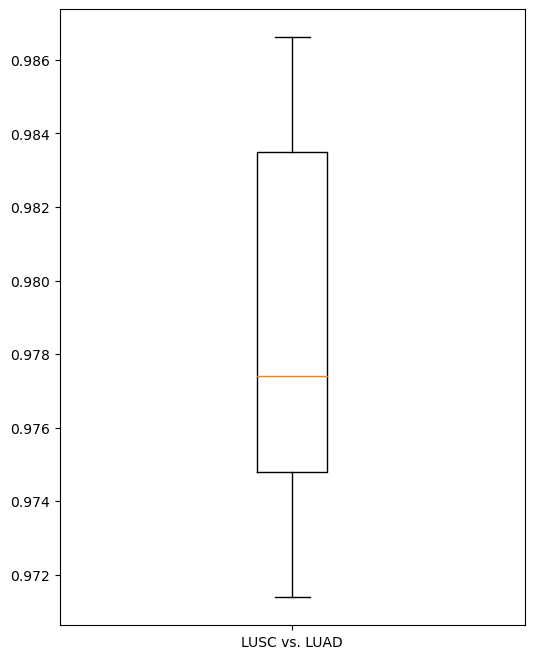

In [191]:
plt.boxplot(auc, labels=['LUSC vs. LUAD'])
plt.savefig('LUSC_vs_LUAD_auc.pdf')
plt.show()

In [22]:
gene_order = pd.DataFrame(imp_genes).mean().sort_values(ascending=False).index
df_sum = pd.DataFrame(imp_genes)

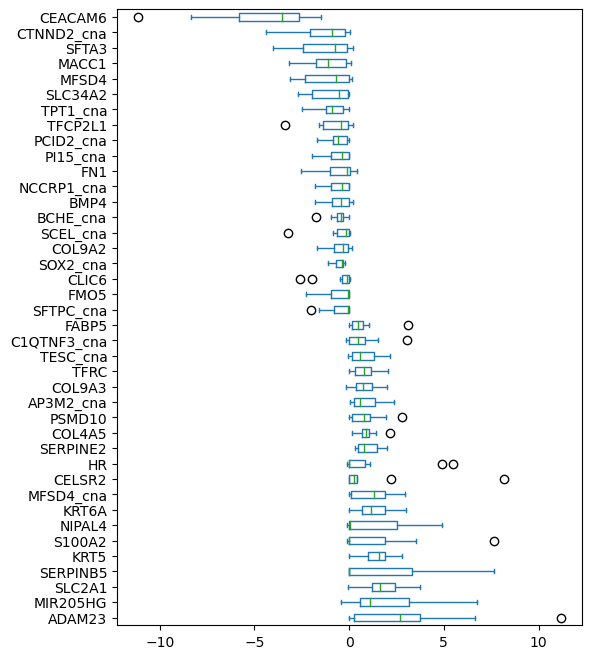

In [192]:
plt.rcParams["figure.figsize"] = (6,8)
df_sum[list(gene_order[:20]) + list(gene_order[-20:])].plot(kind='box', vert=False)
plt.savefig('LUSC_vs_LUAD_important_genes.pdf')
plt.show()

In [54]:
def fold_run_rf(x, y, n):
    aucs = []
    most_imp_genes = []
    for r in range(n):
        print('run: {}'.format(r))
        train_dataset, test_dataset = pnet_loader.generate_train_test(x, y, None, None, 0.3, None)
        clf = RandomForestClassifier()
        clf.fit(train_dataset.input_df.values, train_dataset.target.values.reshape(-1))
        
        x_train = train_dataset.input_df.values
        additional_train = train_dataset.additional_data.values
        y_train = train_dataset.target.values.reshape(-1)
        x_test = test_dataset.input_df.values
        additional_test = test_dataset.additional_data.values
        y_test = test_dataset.target.values.reshape(-1)

        y_pred_proba = clf.predict_proba(x_test)
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba[:,1])
        test_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

        aucs.append(test_auc)

        gene_importances = clf.feature_importances_
        most_imp_genes.append(pd.DataFrame(clf.feature_importances_, index=test_dataset.input_df.columns))
    return aucs, most_imp_genes

In [57]:
auc_rf, genes_rf = fold_run_rf(genetic_data, tumor_type, 10)

run: 0
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
run: 1
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
run: 2
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapping genes
generated input DataFrame of size (297, 1940)
run: 3
Given 2 Input modalities
Found 991 overlapping indicies
Initializing Train Dataset
Found 970 overlapping genes
generated input DataFrame of size (694, 1940)
Initializing Test Dataset
Found 970 overlapp

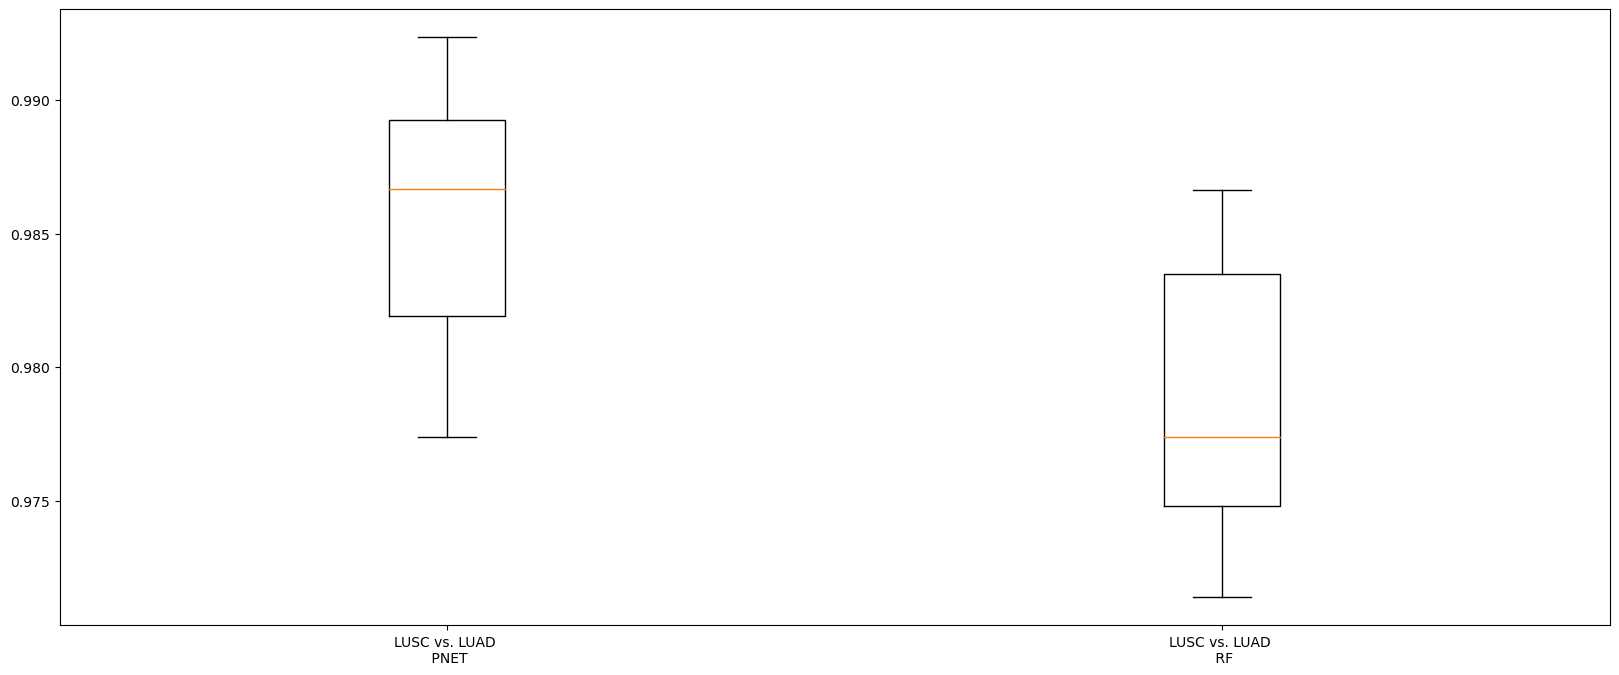

In [59]:
plt.boxplot([auc_rf, auc], labels=['LUSC vs. LUAD \n PNET', 'LUSC vs. LUAD \n RF'])
plt.show()

In [68]:
gene_order_rf = pd.DataFrame([x[0] for x in genes_rf]).mean().sort_values(ascending=False).index
df_sum_rf = pd.DataFrame([x[0] for x in genes_rf])

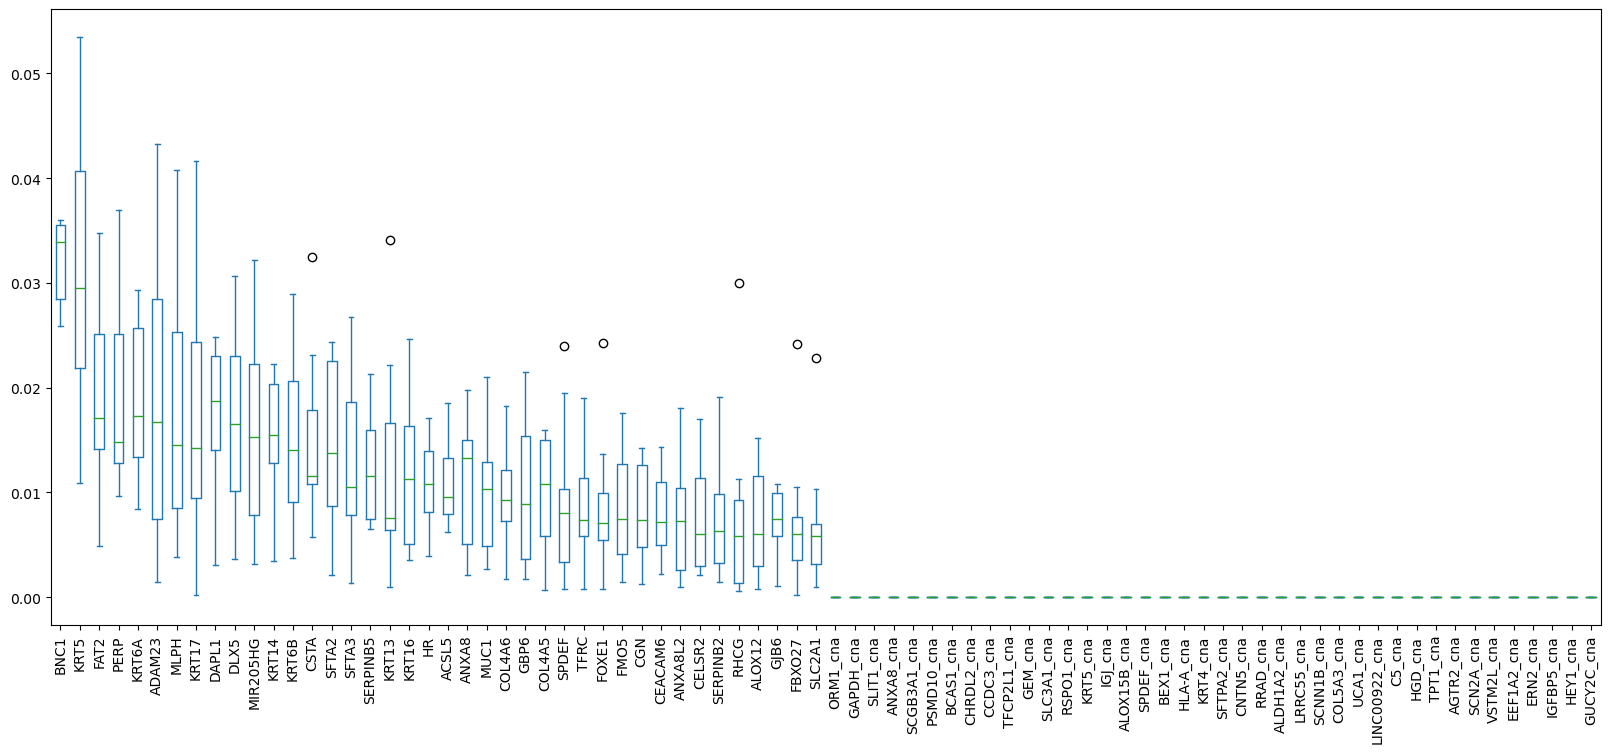

In [69]:
plt.rcParams["figure.figsize"] = (20,8)
df_sum_rf[list(gene_order_rf[:40]) + list(gene_order_rf[-40:])].plot(kind='box')
plt.xticks(rotation=90)
plt.show()

In [ ]:
def check_annotate(x, y):
    if y > 1e-4/(1e-1*x)**1.5:
        return True
    elif y > 1e-3/(x)**2:
        return True
    else:
        return False

In [ ]:
comb_df = pd.DataFrame([df_sum.mean(), df_sum_rf.mean()]).T
comb_df.columns = ['pnet_imp', 'rf_imp']
comb_df['annotate'] = comb_df.apply(lambda x: check_annotate(x['pnet_imp'],x['rf_imp']), axis=1)

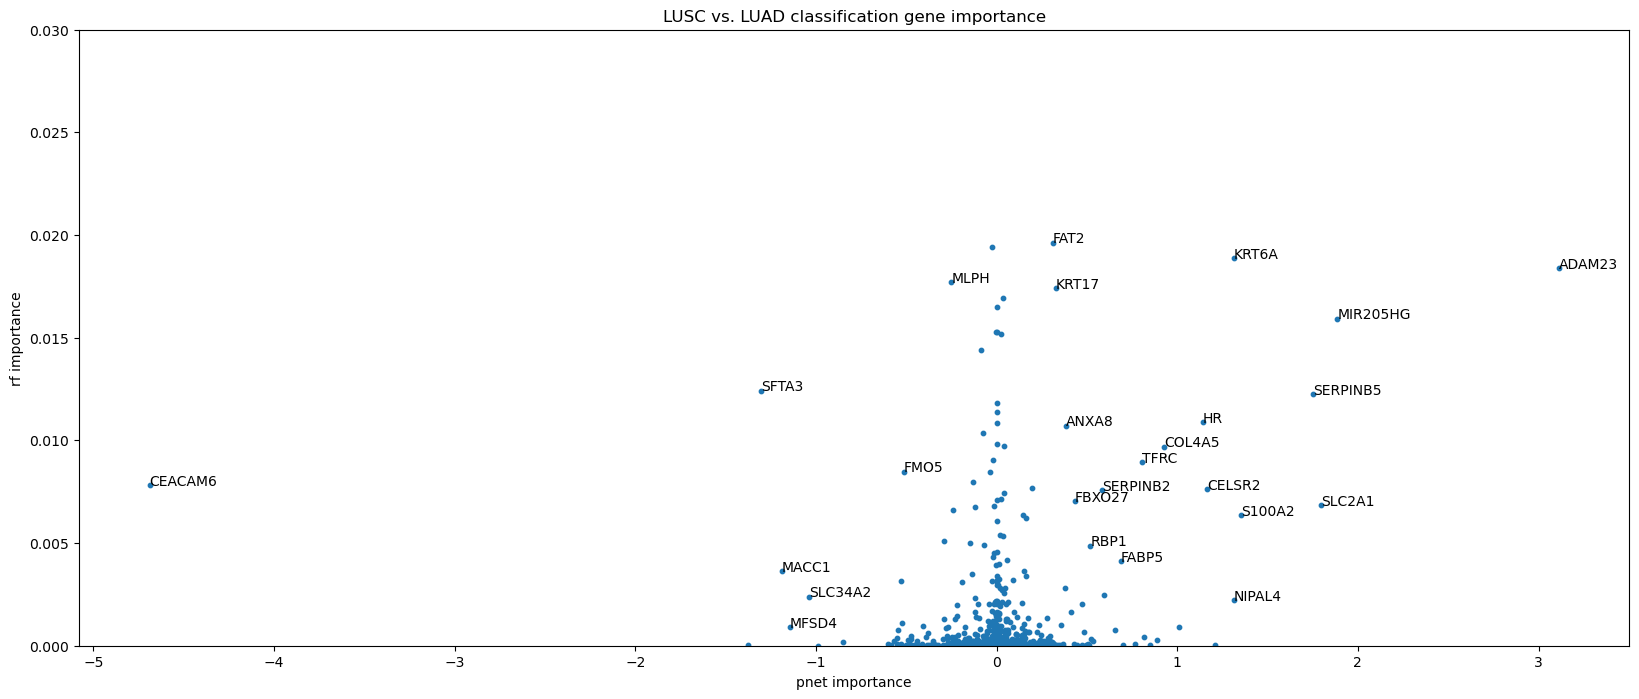

In [174]:
fig, ax = plt.subplots()

plt.ylim(0,0.03)
ax.scatter(comb_df['pnet_imp'], comb_df['rf_imp'], s=10)

for i in range(len(comb_df)):
    if comb_df.iloc[i]['annotate']:
        ax.annotate(comb_df.iloc[i].name, (comb_df.iloc[i]['pnet_imp'], comb_df.iloc[i]['rf_imp']))

plt.ylabel('rf importance')
plt.xlabel('pnet importance')
plt.title('LUSC vs. LUAD classification gene importance')
plt.savefig('important_genes_lusc_luad_scatter.pdf')
plt.show()

Text(0.5, 1.0, 'CEACAM6 distribution in Lusc and Luad')

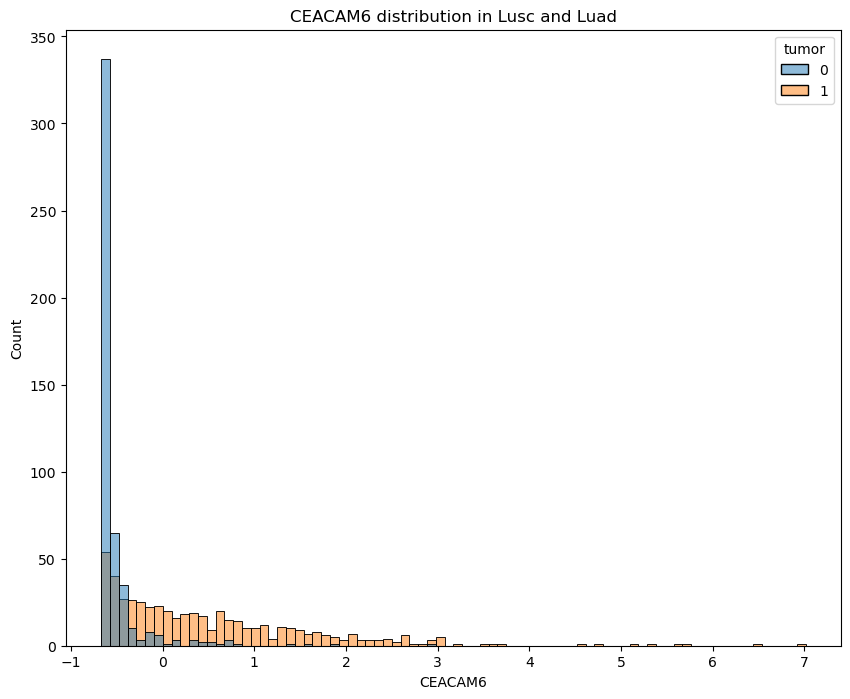

In [199]:
plt.rcParams["figure.figsize"] = (10,8)
plot_df = lusc_luad_rna_exp.join(tumor_type)
sns.histplot(plot_df, x='CEACAM6', hue='tumor', bins=80)
plt.title('CEACAM6 distribution in Lusc and Luad')
#plt.savefig('CEACAM6_dist.pdf')